In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates


In [11]:
# Function to fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Date'] = stock_data.index
    stock_data.reset_index(drop=True, inplace=True)
    return stock_data

# Fetch data for Apple, Microsoft, and Meta
start_date = "2020-01-01"
end_date = "2023-12-31"
apple_data = fetch_stock_data("AAPL", start_date, end_date)
microsoft_data = fetch_stock_data("MSFT", start_date, end_date)
meta_data = fetch_stock_data("META", start_date, end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
# Check and handle missing values
def preprocess_data(data):
    data.dropna(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])
    return data

apple_data = preprocess_data(apple_data)
microsoft_data = preprocess_data(microsoft_data)
meta_data = preprocess_data(meta_data)


In [14]:
# Calculate moving averages and RSI
def add_technical_indicators(data):
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

apple_data = add_technical_indicators(apple_data)
microsoft_data = add_technical_indicators(microsoft_data)
meta_data = add_technical_indicators(meta_data)


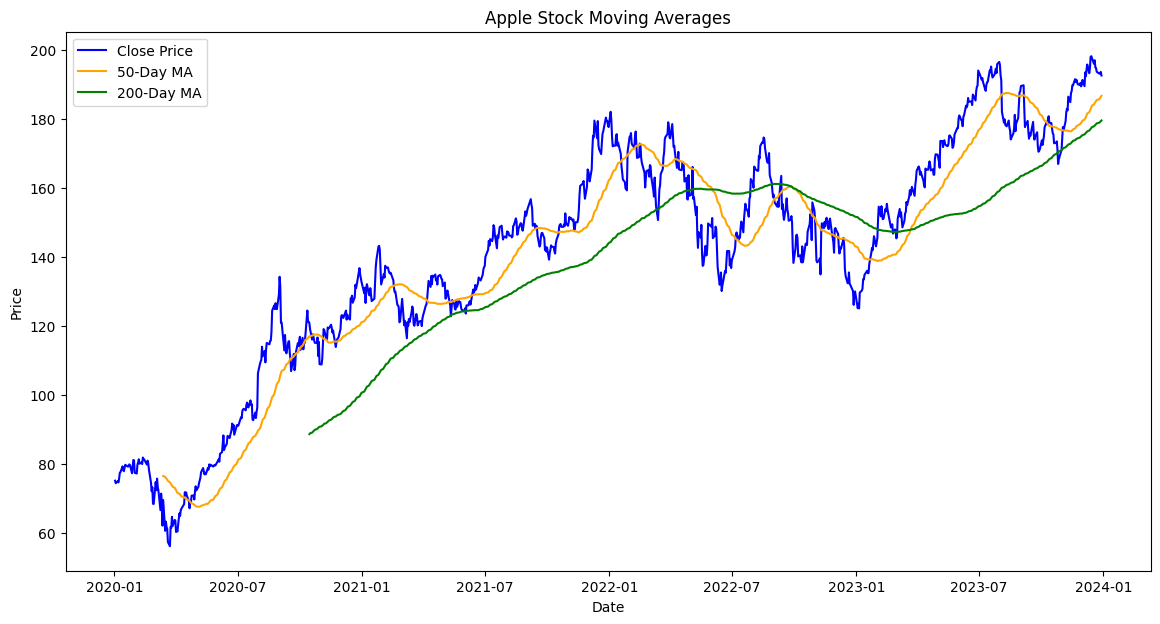

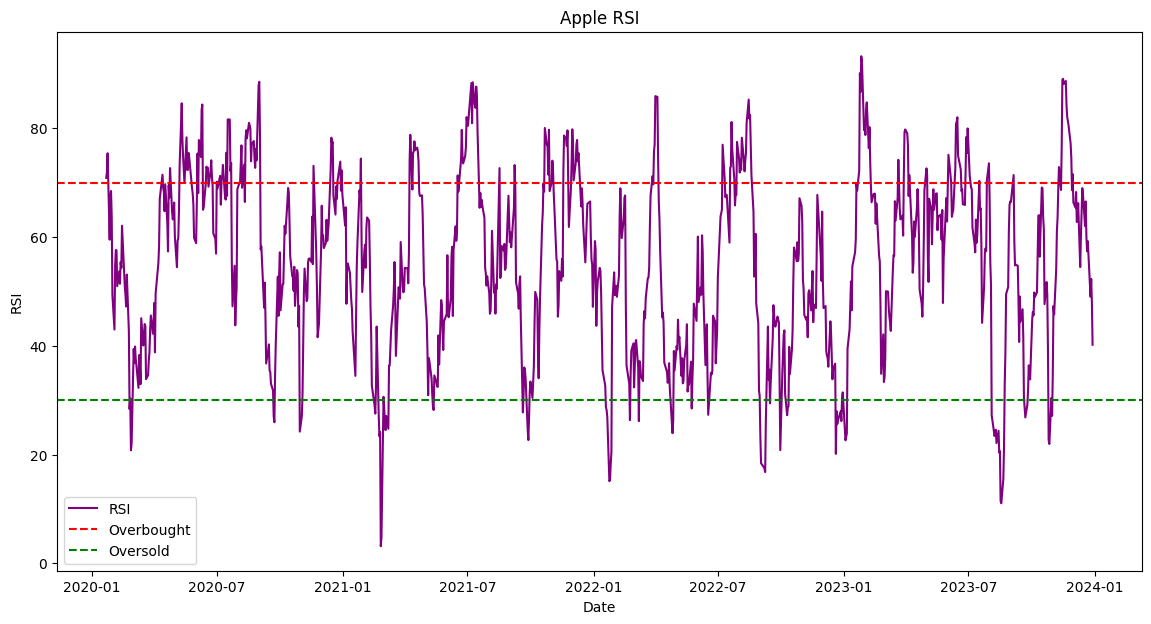

In [15]:
# Plot moving averages and RSI
def plot_moving_averages(data, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label="Close Price", color='blue')
    plt.plot(data['Date'], data['MA50'], label="50-Day MA", color='orange')
    plt.plot(data['Date'], data['MA200'], label="200-Day MA", color='green')
    plt.title(f"{ticker} Stock Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def plot_rsi(data, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['RSI'], label="RSI", color='purple')
    plt.axhline(70, linestyle='--', color='red', label="Overbought")
    plt.axhline(30, linestyle='--', color='green', label="Oversold")
    plt.title(f"{ticker} RSI")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.show()

plot_moving_averages(apple_data, "Apple")
plot_rsi(apple_data, "Apple")


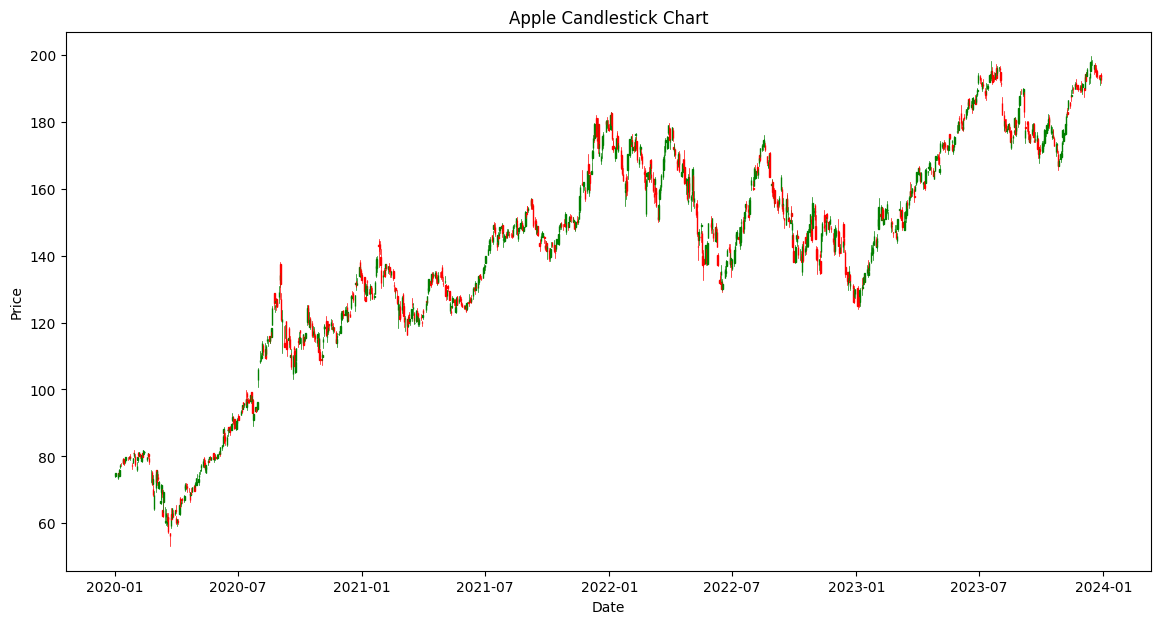

In [16]:
# Create a candlestick chart
def plot_candlestick(data, ticker):
    ohlc = data[['Date', 'Open', 'High', 'Low', 'Close']].copy()
    ohlc['Date'] = ohlc['Date'].map(mdates.date2num)
    fig, ax = plt.subplots(figsize=(14, 7))
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red')
    ax.xaxis_date()
    ax.set_title(f"{ticker} Candlestick Chart")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

plot_candlestick(apple_data, "Apple")


c:\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


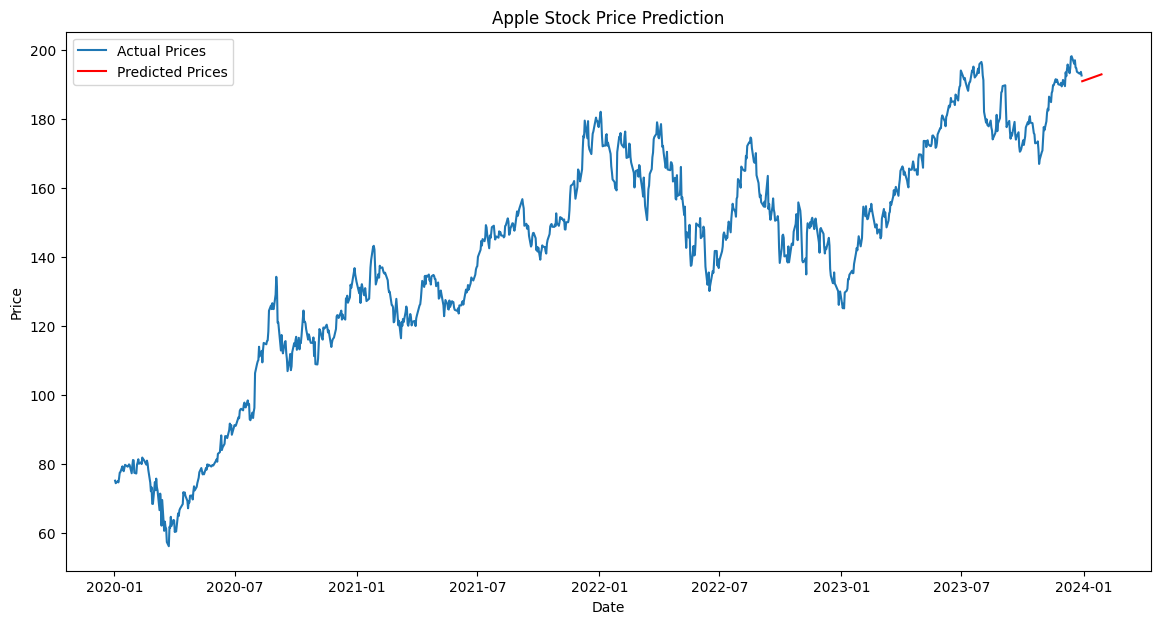

In [17]:
# Linear Regression for stock price prediction
def predict_stock_price(data, days=30):
    data['Date_ordinal'] = data['Date'].apply(lambda x: x.toordinal())
    X = data[['Date_ordinal']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=days + 1, freq='D')[1:]
    future_ordinal = pd.DataFrame({'Date_ordinal': [date.toordinal() for date in future_dates]})
    future_predictions = model.predict(future_ordinal)
    return future_dates, future_predictions

future_dates, future_predictions = predict_stock_price(apple_data)
plt.figure(figsize=(14, 7))
plt.plot(apple_data['Date'], apple_data['Close'], label="Actual Prices")
plt.plot(future_dates, future_predictions, label="Predicted Prices", color='red')
plt.title("Apple Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
